In [ ]:
#| hide
#| default_exp word_embeddings

In [ ]:
#| hide
%matplotlib inline
from nbdev.showdoc import *

# An introduction to word embeddings
(follows: https://github.com/nlptown/nlp-notebooks/blob/master/An%20Introduction%20to%20Word%20Embeddings.ipynb)
(expanded: https://amitness.com/2020/06/fasttext-embeddings)

## Training word embeddings

**Word embeddings** are a form of unsupervised ML that as representations of a bunch of texts (input) show syntactic and semantic "understanding. One of the first algorithms that explored these word embeddings was `word2vec`. We will use this algorithm in this NB. Generating word embeddings we will step into so-called **vector space**.

Suppose we have the following text: "Ronaldo, Messi, Dicaprio".

We can use **one-hot encoding** to give each of the words of this text an unique position:

| -- | isRonaldo | isMessi | isDicaprio |
|----|-----------|---------|------------|
| Ronaldo | 1 | 0 | 0 |
| Messi | 0 | 1 | 0 |
| Dicaprio | 0 | 0 |1 |

The above encoding is not informative at all, there are no relationships between the words, every word is isolated.

We can do better if we use some **world knowledge**: Two of these persons are soccer players, the other is an actor. So we, manually, create **features**:

| -- | isSoccer | isActor |
|----|-----------|---------|
| Ronaldo | 1 | 0 |
| Messi | 1 | 0 |
| Dicaprio | 0 | 1 |

In our simple **two-vector** space, we now get:

-------------Messi, Ronaldo-----> isSoccer

-------------Dicaprio-----------> isActor

We could add a lot more features: Age, gender, height, weight, etc. But that is impossible to do **manually**. So, can we do this: design features based on our world knoweledge of the relationships between words, with **neural nets**? Or, phrased differently, can we have neural nets comb through a large corpus of text and **automatically** generate word representations?

### Word2vec

Formulated in 2013 (Mikolov et al. https://arxiv.org/abs/1301.3781): Efficient method to learn vector representations of words from large amount of unstructured texts. Based on the idea of **distributional semantics**: "You shall know a word by the company it keeps" (J.R. Firth, 1957). Or, similar words appear in similar contexts.

Word2vec representation learning:

1. Continuous Bag of Words (CBOW): Given neighbouring words, predict the center word
2. Skip-gram: Given the center word, predict the neigbouring words

There is room for improvement here:

- Out of vocabulary (OOV) words. w2v can't handle words that are not in its vocabulary (seen during training).
- Morphology. Use internal structure of words (radicals, lemma's: eat, eats, eaten, eater, eating) to get better vectors.

### FastText

Bojanowski et al. (https://arxiv.org/abs/1607.04606) proposed a new embedding theory using the two improvement ideas: **FastText**.

1. Use the internal structure of a word to improve vector representations obtained by the skip-gram methode:

    1.1 sub-word generation using n-grams via windowing:
    <eating> -> <ea eat ati tin ing ng> (for 3-grams); but because this explodes:

    1.2 hashing n-grams into buckets with an index: <ing> -> 10
  
2. Skip-gram with negative sampling

FastText is really good on syntactic word analogy tasks in morphologically rich languages (German):

- cat -> cats
- dog -> ?
- good -> better
- rough -> ?

Not as good on semantic analogy tasks:

- man -> king
- woman -> ?

FastText is not as fast as word2vec.



Here we use Gensim and word2vec, although FastText is also available in the Gensim library. We use the abstracts of all arXiv papers in the category cs.CL (CL: Computation and Language) published before mid-April 2021 (c. 25_000 documents). We tokenize the abstracts with spaCy. Note that the texts we work with share a context (Computation and Language)! Each row in the CSV file consists of two columns: 1. title and 2. abstract. We use the abstracts for the construction of our model.

In [ ]:
#| export
import sys
import os
import csv
import spacy
import gensim
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
#|export

class Corpus(object):
    def __init__(self, filename):
        self.filename = filename
        self.nlp = spacy.blank("en")

    def __iter__(self):
        with open(self.filename, "r") as i:
            reader = csv.reader(i, delimiter=',')
            for _, abstract in reader:
                tokens = [t.text.lower() for t in self.nlp(abstract)]
                yield tokens

documents = Corpus("/home/peter/Documents/data/nlp/arxiv.csv")
model = gensim.models.Word2Vec(documents, min_count=100, window=5, vector_size=100) # We use the default CBOW algorithm

Using Gensim we can set a number of parameters for training:

- min_count: the minimum frequency of words in our corpus
- window: number of words to the left and right to make up the context that word2vec will take into account
- vector_size: the dimensionality of the word vectors; usually between 100 and 1_000
- sg: One can choose fro 2 algorithms to train word2vec: Skip-gram (sg) tries to predict the context on the basis of the target word; CBOW tries to find the target on the basis of the context. Default is sg=0, hence: default is CBOW.

## Using word embeddings

With the model trained, we can access the word embedding via the **wv** attribute on model using the token as a key. For example the embedding for "nlp" is:

In [ ]:
#| export
model.wv["nlp"]

array([ 2.3895645e+00, -1.8587983e+00,  1.0197790e+00, -6.8859214e-01,
        1.0019319e+00, -2.3214912e-01,  1.5533881e+00, -9.1230834e-01,
       -9.2871404e-01,  2.2949359e+00,  5.8229566e-01, -6.5898842e-01,
        1.2704480e+00,  7.7040613e-02,  1.0018349e-01,  8.3510602e-01,
       -9.9827307e-01,  2.6916058e+00,  3.7778455e-01,  2.1215007e+00,
        1.1456664e+00, -1.2086145e+00,  1.1572634e+00,  6.7397945e-02,
       -4.0439677e+00, -2.4220943e+00,  5.9777898e-01, -2.1234183e-01,
        1.5394293e+00, -3.6740437e-01,  1.8242909e+00,  5.2429348e-01,
        5.7699573e-01,  5.5333054e-01,  6.4802444e-01, -1.2687025e+00,
       -2.0218377e-01, -3.9209683e+00, -7.5698555e-02,  1.9709581e+00,
       -1.9199218e+00, -1.7871165e+00,  2.0837519e+00,  5.8999747e-01,
       -2.0494442e+00,  8.2008713e-01,  1.5566676e+00,  1.7762532e+00,
       -2.2493783e-01, -3.1665981e+00,  1.6813955e+00, -3.3866838e-02,
       -4.0111634e-01, -5.8645862e-01,  7.6609558e-01,  2.7404958e-01,
      

**Find the similarity between two words.** We use the cosine between two word embeddings, so we use a ranges between -1 and +1. The higher the cosine, the more similar two words are.

In [ ]:
#| export
print(model.wv.similarity("nmt", "smt"))
print(model.wv.similarity("nmt", "ner"))

0.6686505
0.3927191


**Find words that are most similar to target words** we line up words via the embeddings: semantically related, other types of pre-tained models, related general models, and generally related words:

In [ ]:
#| export
model.wv.similar_by_word("bert", topn=10)

[('roberta', 0.7977496385574341),
 ('transformer', 0.7762178182601929),
 ('elmo', 0.7304530143737793),
 ('transformers', 0.7174931168556213),
 ('pretrained', 0.6988838315010071),
 ('xlm', 0.6597242951393127),
 ('xlnet', 0.639888346195221),
 ('mbert', 0.632975161075592),
 ('gpt-2', 0.6320061683654785),
 ('lstm', 0.6231904625892639)]

**Look for words that are similar to something, but dissimilar to something else** with this we can look for a kind of **analogies**:

In [ ]:
#| export
model.wv.most_similar(positive=["transformer", "lstm"], negative=["bert"], topn=1)

[('rnn', 0.8297603726387024)]

So a related transformer to lstm is rnn, just like bert is a particular type of transformer; really powerful.

We can also zoom in on **one of the meanings of ambiguous words**. In NLP **tree** has a very specific meaning, is nearest neighbours being: constituency, parse, dependency, and syntax:

In [ ]:
#| export
model.wv.most_similar(positive=["tree"], topn=10)

[('trees', 0.7888379693031311),
 ('constituency', 0.7310193181037903),
 ('parse', 0.6989930272102356),
 ('recursive', 0.667879581451416),
 ('dependency', 0.6263459324836731),
 ('formalism', 0.6166130304336548),
 ('syntax', 0.6132522225379944),
 ('grammar', 0.6023567914962769),
 ('parser', 0.5969383120536804),
 ('constituent', 0.5896958708763123)]

If we add **syntax** as a negative input to the query, we see that the ordinary meaning of tree kicks in: Now forest is one of the nearest neighbours.

In [ ]:
#| export
model.wv.most_similar(positive=["tree"], negative=["syntax"], topn=10)

[('forest', 0.4937039315700531),
 ('crf', 0.4432641863822937),
 ('greedy', 0.43900948762893677),
 ('modified', 0.4175686836242676),
 ('binary', 0.4161542057991028),
 ('random', 0.403143048286438),
 ('bayes', 0.4014485776424408),
 ('softmax', 0.39950811862945557),
 ('logistic', 0.3990311026573181),
 ('beam', 0.3890570402145386)]

**Throw a list of words at the model** and filter out the odd one (here svm is the only non-neural model):

In [ ]:
#| export
print(model.wv.doesnt_match("lst cnn gru transformer svm".split()))

svm


## Plotting embeddings

About visualizing embeddings. We need to reduce our 100-dimensions space to 2-dimensions. We can use t-SNE method: map similar data to nearby points and dissimilar data to faraway points in low dimensional space.

t-SNE is present in Scikit-learn. One has to specify two parameters: **n_components** (number of dimensions) and **metric** (similarity metric, here: cosine).

In order NOT to overcrowd the image we use a subset of embeddings of 200 most similar words based on a **target word**.

In [ ]:
#| export
target_word = "bert"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=200)] + [target_word]
embeddings = [model.wv[w] for w in selected_words] + model.wv["bert"]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

/home/peter/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/peter/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/peter/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


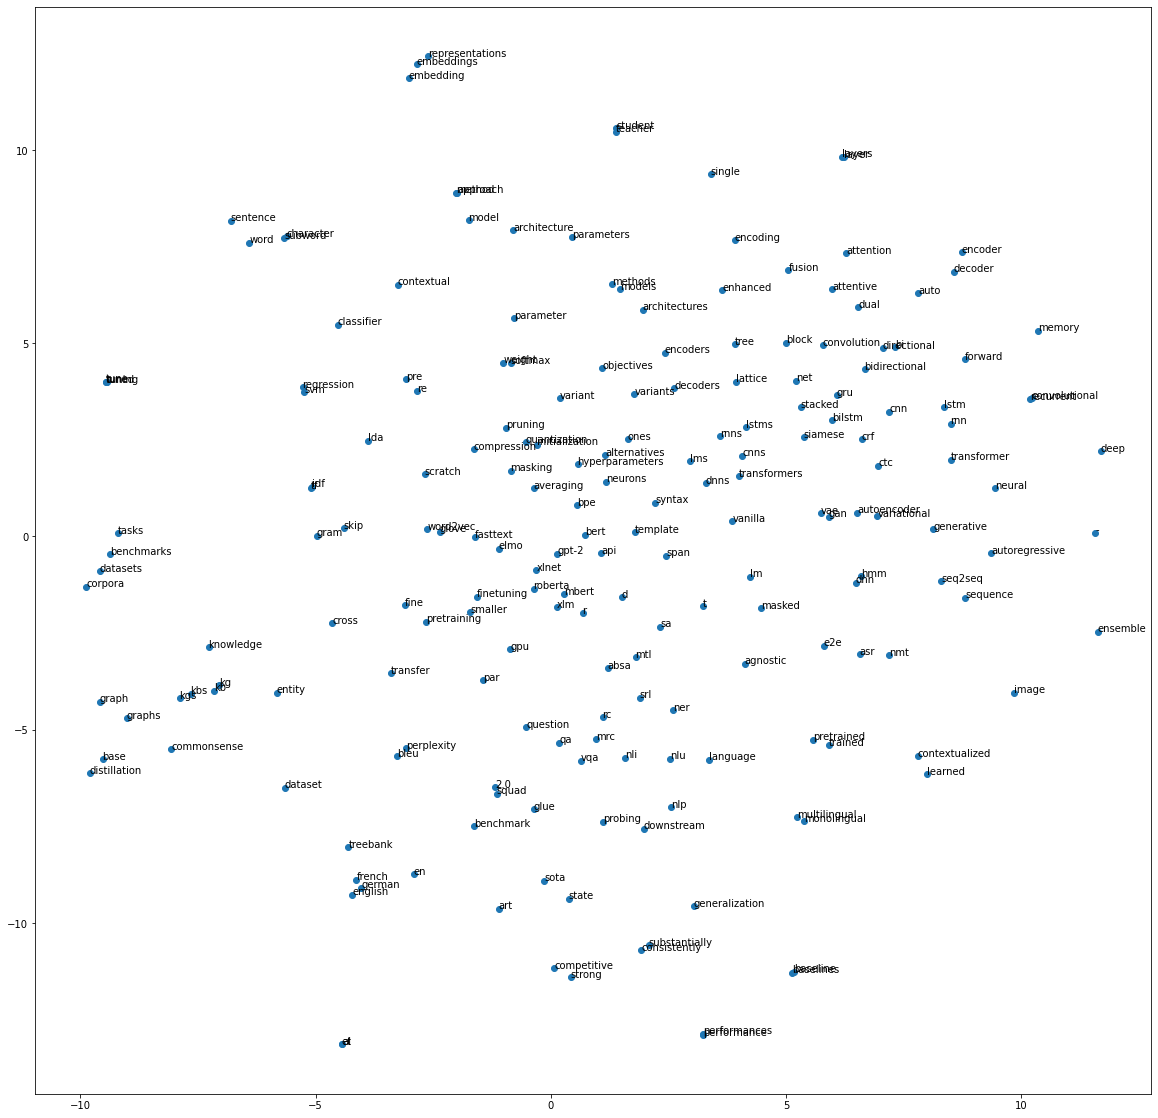

In [ ]:
#| export
plt.figure(figsize=(20,20))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]))

## Exploring hyperparameters

What is the quality of the embeddings? Should embeddings capture syntax or semantical relations. Semantic similarity or topical relations?

One way of monitoring the quality is to check nearest neighbours: Are they two nouns, two verbs?

In [ ]:
#| export
nlp = spacy.load('en_core_web_sm')

word2pos = {}
for word in model.wv.key_to_index: # model call can be 
    word2pos[word] = nlp(word)[0].pos_

word2pos["translation"]

'NOUN'

In [ ]:
#| export
def evaluate(model, word2pos):
    same = 0
    for word in model.wv.key_to_index:
        most_similar = model.wv.similar_by_word(word, topn=1)[0][0]
        if word2pos[most_similar] == word2pos[word]:
            same = same + 1
    return same/len(model.wv.key_to_index)

evaluate(model, word2pos)

0.6621490803484995

Now we want to change some of the settings we used above:

- embedding size (dimensions of the trained embeddings): 100, 200, 300
- context window: 2, 5, 10

We will use a Pandas dataframe to keep track of the different scores (but this will take time: We train 9 models!!!):

In [ ]:
#| export
sizes = [100, 200, 300]
windows = [2,3,5,10]

df = pd.DataFrame(index=windows, columns=sizes)

for size in sizes:
    for window in windows:
        print("Size:", size, "Window:", window)
        model = gensim.models.Word2Vec(documents, min_count=100, window=window, vector_size=size)
        acc = evaluate(model, word2pos)
        df[size][window] = acc
        
df

Size: 100 Window: 2
Size: 100 Window: 3
Size: 100 Window: 5
Size: 100 Window: 10
Size: 200 Window: 2
Size: 200 Window: 3
Size: 200 Window: 5
Size: 200 Window: 10
Size: 300 Window: 2
Size: 300 Window: 3
Size: 300 Window: 5
Size: 300 Window: 10


,100,200,300
2,0.688609,0.695386,0.685382
3,0.679574,0.682478,0.684092
5,0.656986,0.664408,0.663763
10,0.63343,0.631494,0.635044


Results are close:

1. Smaller contexts seem to yield better results. Which makes sense because we work with the syntax - nearer words often produce more information.
2. Higher dimension word embeddings not always work better than lower dimension. Here we have a relatively small corpus, not enough data for such higher dimensions.

Let's visualize our findings:

<AxesSubplot:>

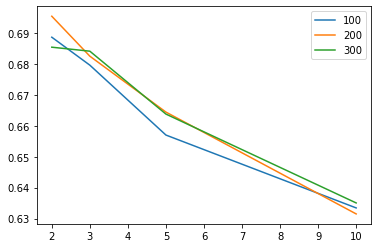

In [ ]:
#| export
df.plot()

## Conclusions

Word embeddings allow us to model the usage and meaning of a word, and discover words that behave in a similar way.

We move from raw strings -> vector space: word embeddings which allows us to work with words that have a similar meaning and discover new patterns.

## Variables in this Notebook

| Name | Type | Cell # | Size | Value(s) |
|------|------|--------|------|----------|
| acc  | float | 20    | --   | 0.6350   |
| df   | DataFrame | 20 | (4, 3) | 100 200 300 2 0.688609 |
| documents | Corpus | 4 | -- | <\_\_main\_\_.corpus object at ...> |
| embeddings | ndarray | 15  | (201, 100) | [[1.36567 -2.2555 ...] [...]] |
| mapped_embeddings | ndarray | 15 | (201, 2) | [[-0.3663 -1.3517] [8.5049 ...]] |
| model | Word2Vec | 20 | -- | Word2Vec(vocab=3099, vector_size=300, alpha=0.025) |
| nlp | English | 17 | -- | spacy.lang.en.English object at ... |
| selected_words | list | 15 | 201 | ['roberta', 'transformer', 'elmo' ...]
| target_word | str | 15 | 4 | 'bert' |
| word | str | 18 | 7 | 'careful' |
| word2pos | dict | 17 | 3099 | {'\n': 'SPACE', 'the': 'PRON', ...} |
| x | ndarray | 16 | (201,) | [-0.3666572 8.504919 ...] |
| y | ndarray | 16 | (201,) | [-1.3517823 1.9856246 ...]  |


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()